In [348]:
import warnings
warnings.filterwarnings('ignore')

In [349]:
import numpy as np
import pandas as pd
import re, random, time
from  sklearn.metrics import mean_squared_log_error 
from  sklearn.metrics import mean_squared_log_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr
pd.options.display.max_columns = 1000

In [452]:
df_train = pd.read_csv('train/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('test.csv', encoding="ISO-8859-1")
fulfilment_center_info = pd.read_csv('train/fulfilment_center_info.csv')
meal_info = pd.read_csv('train/meal_info.csv')

In [453]:
df_train = df_train.merge(fulfilment_center_info, how = 'left', on = 'center_id')
df_train = df_train.merge(meal_info, how = 'left', on = 'meal_id')
df_train['Istrain'] = 1

df_test = df_test.merge(fulfilment_center_info, how = 'left', on = 'center_id')
df_test = df_test.merge(meal_info, how = 'left', on = 'meal_id')
df_test['Istrain'] = 0

df_all = df_train.append(df_test)
print(df_test.shape, df_train.shape, df_all.shape)
df_all.tail(2)

(32573, 15) (456548, 16) (489121, 16)


,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week
32571,0,323.07,Salad,61,TYPE_A,322.07,473,Italian,0,0,1444235,2569,NaN,4.5,77,155
32572,0,276.45,Salad,61,TYPE_A,276.45,473,Italian,0,0,1291286,2490,NaN,4.5,77,155


In [457]:
# avg_price_region = df_all[['region_code', 'base_price', 'checkout_price']].groupby('region_code', as_index = False).mean()
# avg_price_region.columns = ['region_code', 'avg_base_price_region', 'avg_checkout_price_region']
# df_all = df_all.merge(avg_price_region, how = 'left', on='region_code')

# avg_price_city = df_all[['city_code', 'base_price', 'checkout_price']].groupby('city_code', as_index = False).mean()
# avg_price_city.columns = ['city_code', 'avg_base_price_city', 'avg_checkout_price_city']
# df_all = df_all.merge(avg_price_city, how = 'left', on='city_code')

avg_price_meal = df_all[['meal_id', 'base_price', 'checkout_price']].groupby('meal_id', as_index = False).mean()
avg_price_meal.columns = ['meal_id', 'avg_base_price_meal', 'avg_checkout_price_meal']
df_all = df_all.merge(avg_price_meal, how = 'left', on='meal_id')

avg_price_center = df_all[['center_id', 'base_price', 'checkout_price']].groupby('center_id', as_index = False).mean()
avg_price_center.columns = ['center_id', 'avg_base_price_center', 'avg_checkout_price_center']
df_all = df_all.merge(avg_price_center, how = 'left', on='center_id')

avg_price_center_meal = df_all[['center_id','meal_id', 'base_price', \
                                'checkout_price']].groupby(['center_id', 'meal_id'], as_index = False).mean()
avg_price_center_meal.columns = ['center_id', 'meal_id', 'avg_base_price', 'avg_checkout_price']
df_all = df_all.merge(avg_price_center_meal, how = 'left', on=['meal_id','center_id'])


cnt_homepage_meal = df_all[['homepage_featured', 'meal_id']].groupby('meal_id', as_index = False).sum()
cnt_homepage_meal.columns = ['meal_id', 'cnt_homepage_meal']
df_all = df_all.merge(cnt_homepage_meal, how = 'left', on='meal_id')


# cnt_email_meal = df_all[['emailer_for_promotion', 'meal_id']].groupby('meal_id', as_index = False).sum()
# cnt_email_meal.columns = ['meal_id', 'cnt_email_meal']
# df_all = df_all.merge(cnt_email_meal, how = 'left', on='meal_id')

# cnt_email_center = df_all[['emailer_for_promotion', 'center_id']].groupby('center_id', as_index = False).sum()
# cnt_email_center.columns = ['center_id', 'cnt_email_center']
# df_all = df_all.merge(cnt_email_center, how = 'left', on='center_id')

cnt_homepage_center = df_all[['homepage_featured', 'center_id']].groupby('center_id', as_index = False).sum()
cnt_homepage_center.columns = ['center_id', 'cnt_homepage_center']
df_all = df_all.merge(cnt_homepage_center, how = 'left', on='center_id')

In [458]:
# df_all.base_price.dtype
# for col in [x for x in temp.columns if temp[x].dtype != 'O' and x != 'Istrain']:
#     print (col, np.round(pearsonr(temp.num_orders, temp[col])[0],2) )

# categorical to numeric

In [459]:
cat_columns = [x for x in df_all.columns if df_all[x].dtype == 'O']
# cat_columns = cat_columns + ['city_code', 'region_code']
for col in cat_columns:
    df_all[col] = pd.factorize(df_all[col])[0]
df_all.head(2)

,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,avg_base_price_meal,avg_checkout_price_meal,avg_base_price_center,avg_checkout_price_center,avg_base_price,avg_checkout_price,cnt_homepage_meal,cnt_homepage_center
0,1,152.29,0,55,0,136.83,647,0,0,0,1379560,1885,177.0,2.0,56,1,130.283937,127.032705,352.324303,326.935824,146.560390,142.223766,3119,330
1,1,135.83,0,55,0,136.83,647,0,0,0,1466964,1993,270.0,2.0,56,1,130.305317,127.225190,352.324303,326.935824,146.620839,142.791290,3126,330


In [461]:
df_all.tail(2)

,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,avg_base_price_meal,avg_checkout_price_meal,avg_base_price_center,avg_checkout_price_center,avg_base_price,avg_checkout_price,cnt_homepage_meal,cnt_homepage_center
489119,0,323.07,12,61,2,322.07,473,2,0,0,1444235,2569,NaN,4.5,77,155,320.671060,313.252998,360.705269,340.171782,320.500803,315.107445,360,652
489120,0,276.45,12,61,2,276.45,473,2,0,0,1291286,2490,NaN,4.5,77,155,262.991272,249.361602,360.705269,340.171782,257.729154,249.217846,1035,652


# create rolling orders column 

In [1]:
df_week = df_all[['week']].drop_duplicates()
cid_mid = df_all[['meal_id', 'center_id']].drop_duplicates()
cid_mid_list = [(x,y) for x, y in zip(cid_mid.center_id, cid_mid.meal_id)]

df_all_corrected = pd.DataFrame()
for i, (cid, mid) in enumerate(cid_mid_list):
    temp = df_all[(df_all.center_id == cid) & (df_all.meal_id == mid)].reset_index(drop = True)
#     print ('pre', i, temp.shape)
    temp = temp.merge(df_week, how = 'right', on = 'week')
    temp.center_id , temp.meal_id =  cid, mid
    temp.num_orders.fillna(0, inplace=True)
    temp.fillna(method='bfill', inplace= True)
    temp.fillna(method='ffill', inplace= True)
    temp.sort_values(by = 'week', inplace= True)
#     print ('post',i,cid, mid, temp.shape)
    df_all_corrected = df_all_corrected.append(temp)        

In [442]:
df_all_corrected1  = df_all_corrected.copy()
df_all_corrected1.num_orders = [np.nan if x >= 146 else y for x,y in \
                                zip(df_all_corrected1.week, df_all_corrected1.num_orders)]

# avg10

In [443]:
df_all_corrected1.tail(2)

,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,avg_base_price_meal,avg_checkout_price_meal,avg_base_price_center,avg_checkout_price_center,avg_base_price,avg_checkout_price,cnt_homepage_meal,cnt_homepage_center
5,0.0,678.03,13.0,73,2.0,679.03,576.0,3.0,0.0,0.0,1174372.0,2956,NaN,4.0,34.0,154,599.132903,583.867073,349.401255,329.542114,650.752857,651.038571,123.0,694.0
6,0.0,679.03,13.0,73,2.0,678.03,576.0,3.0,0.0,0.0,1169548.0,2956,NaN,4.0,34.0,155,599.132903,583.867073,349.401255,329.542114,650.752857,651.038571,123.0,694.0


In [444]:
df_all_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=10).mean()).reset_index(name='num_orders_10_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])
df_all_corrected1.head()

,Istrain,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,avg_base_price_meal,avg_checkout_price_meal,avg_base_price_center,avg_checkout_price_center,avg_base_price,avg_checkout_price,cnt_homepage_meal,cnt_homepage_center,num_orders_10_week
0,1.0,152.29,0.0,55,0.0,136.83,647.0,0.0,0.0,0.0,1379560.0,1885,177.0,2.0,56.0,1,130.283937,127.032705,352.324303,326.935824,146.56039,142.223766,3119.0,330.0,NaN
1,1.0,152.29,0.0,55,0.0,135.83,647.0,0.0,0.0,0.0,1018704.0,1885,323.0,2.0,56.0,2,130.283937,127.032705,352.324303,326.935824,146.56039,142.223766,3119.0,330.0,177.000000
2,1.0,133.92,0.0,55,0.0,132.92,647.0,0.0,0.0,0.0,1196273.0,1885,96.0,2.0,56.0,3,130.283937,127.032705,352.324303,326.935824,146.56039,142.223766,3119.0,330.0,250.000000
3,1.0,134.86,0.0,55,0.0,135.86,647.0,0.0,0.0,0.0,1116527.0,1885,163.0,2.0,56.0,4,130.283937,127.032705,352.324303,326.935824,146.56039,142.223766,3119.0,330.0,198.666667
4,1.0,147.50,0.0,55,0.0,146.50,647.0,0.0,0.0,0.0,1343872.0,1885,215.0,2.0,56.0,5,130.283937,127.032705,352.324303,326.935824,146.56039,142.223766,3119.0,330.0,189.750000


# avg 5- 9

In [445]:
#avg9
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=9).mean()).reset_index(name='num_orders_9_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])


#avg8
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=8).mean()).reset_index(name='num_orders_8_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])


#avg7
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=7).mean()).reset_index(name='num_orders_7_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])


#avg6
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=6).mean()).reset_index(name='num_orders_6_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])


df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=5).mean()).reset_index(name='num_orders_5_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])

# avg 4-1

In [446]:
#avg4
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=4).mean()).reset_index(name='num_orders_4_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])

#avg3
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=3).mean()).reset_index(name='num_orders_3_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])

#avg2
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=2).mean()).reset_index(name='num_orders_2_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])

#avg1
df_all_corrected1_sorted = df_all_corrected1[[ 'center_id', 'meal_id', 'week', 'num_orders']].sort_values(by = \
                                                    ['center_id', 'meal_id', 'week'])
temp1 = df_all_corrected1_sorted.groupby(['center_id', 'meal_id']).apply(lambda x: x.set_index('week'))
temp2 = temp1.groupby(['center_id', 'meal_id'])['num_orders'].apply(lambda x: \
                    x.shift().rolling(min_periods=1,window=1).mean()).reset_index(name='num_orders_1_week')
df_all_corrected1 = df_all_corrected1.merge(temp2, how = 'left', on=['center_id', 'meal_id', 'week'])

In [448]:
for col in [x for x in df_all_corrected1.columns if df_all_corrected1[x].dtype != 'O' and x != 'Istrain']:
    temp = df_all_corrected1[(~df_all_corrected1.num_orders.isnull()) & (~df_all_corrected1[col].isnull())]
    print (col, np.round(pearsonr(temp.num_orders, temp[col])[0],5) )

base_price -0.24232
category -0.2019
center_id -0.05111
center_type 0.06009
checkout_price -0.29854
city_code 0.03843
cuisine -0.05563
emailer_for_promotion 0.28815
homepage_featured 0.30645
id -0.00193
meal_id 0.00323
num_orders 1.0
op_area 0.19204
region_code 0.02732
week 0.0099
avg_base_price_meal -0.24671
avg_checkout_price_meal -0.24785
avg_base_price_center 0.07142
avg_checkout_price_center 0.06947
avg_base_price -0.24071
avg_checkout_price -0.24009
cnt_homepage_meal 0.17455
cnt_homepage_center 0.15252
num_orders_10_week 0.70983
num_orders_9_week 0.70629
num_orders_8_week 0.70317
num_orders_7_week 0.6989
num_orders_6_week 0.69638
num_orders_5_week 0.69724
num_orders_4_week 0.69906
num_orders_3_week 0.70426
num_orders_2_week 0.71471
num_orders_1_week 0.71331


In [494]:
import pandas_profiling
pandas_profiling.ProfileReport(df_all)

Number of variables,24
Number of observations,489121
Total Missing (%),0.3%
Total size in memory,93.3 MiB
Average record size in memory,200.0 B
Numeric,15
Categorical,0
Boolean,3
Date,0
Text (Unique),0
Rejected,6


# separting train and test dataset

In [495]:
df_train_corrected = df_all_corrected1[df_all_corrected1.week < 146].reset_index(drop = \
                                                                                 True).drop('Istrain', axis = 1)
df_test_corrected = df_all_corrected1[df_all_corrected1.week >= 146].reset_index(drop = \
                                                                                 True).drop('Istrain', axis = 1)
print(df_test_corrected.shape, df_train_corrected.shape, df_all_corrected1.shape)

(36000, 33) (522000, 33) (558000, 34)


# splitting train into train and valid dataset

In [499]:
df_train1 = df_train_corrected[df_train_corrected.week <= 135].sample(frac=1)
df_valid1 = df_train_corrected[df_train_corrected.week > 135]
print(df_train1.shape, df_valid1.shape)

(486000, 33) (36000, 33)


# from validation and test datasets removing extra rows

In [500]:
df_train_cmw = df_train[['center_id', 'meal_id', 'week']].drop_duplicates()
df_valid1 = df_valid1.merge(df_train_cmw, how = 'inner', on = ['center_id', 'meal_id', 'week'] )
print (df_valid1.shape, df_train.shape)

df_test_cmw = df_test[['center_id', 'meal_id', 'week']].drop_duplicates()
df_test_corrected = df_test_corrected.merge(df_test_cmw, how = 'inner', on = ['center_id', 'meal_id', 'week'] )
print (df_test_corrected.shape, df_test.shape, df_test_cmw.shape)

(32821, 33) (456548, 16)
(32573, 33) (32573, 15) (32573, 3)


In [501]:
train_X_all = df_train_corrected.drop(['week', 'id', 'num_orders', 'center_id', 'meal_id',], axis = 1)
train_Y_all = df_train_corrected.num_orders
train_X = df_train1.drop(['week', 'id','num_orders', 'center_id', 'meal_id',], axis = 1)
train_Y = df_train1.num_orders
valid_X = df_valid1.drop(['week', 'id','num_orders', 'center_id', 'meal_id',], axis = 1)
valid_Y = df_valid1.num_orders
test_X = df_test_corrected.drop(['week', 'id', 'num_orders', 'center_id', 'meal_id',], axis = 1)
print(train_X.shape, train_Y.shape, test_X.shape, valid_X.shape)

(486000, 28) (486000,) (32573, 28) (32821, 28)


In [502]:
def rmsle(y_hat, data):
#     print (data)
    y_true = data.get_label() # scikits f1 doesn't like probabilities
    y_hat[y_hat < 0] = 0
    return 'RMSLE', -np.sqrt(mean_squared_log_error(y_true, y_hat)) * 100, True

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's RMSLE: -62.2363
[200]	valid_0's RMSLE: -52.1328
[300]	valid_0's RMSLE: -52.063
[400]	valid_0's RMSLE: -56.1933
Early stopping, best iteration is:
[243]	valid_0's RMSLE: -51.4388
Plot feature importances...


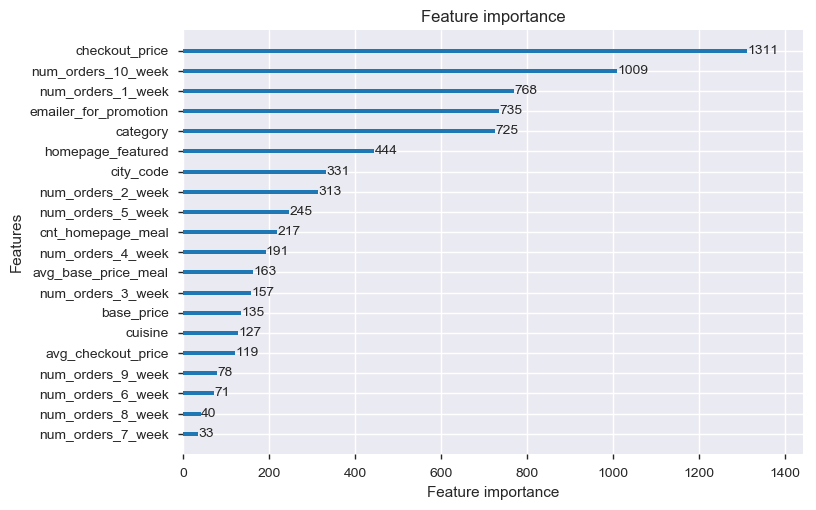

In [529]:
params = { 
    'learning_rate': 0.01, 
    'boosting': 'gbdt', 
    'objective': 'regression_l1', 
    'metric': 'rmsle',
    'is_training_metric': True, 
    'seed': 0 
}

fit_model = lgb.train( params, train_set= lgb.Dataset(train_X, label=train_Y.values), num_boost_round= 5000,
            valid_sets = [lgb.Dataset(valid_X, label=valid_Y.values)], feval = rmsle,  verbose_eval = 100, \
            categorical_feature=['region_code','city_code', 'category', \
                                 'center_type', 'cuisine']  ,early_stopping_rounds = 200)

valid_pred = fit_model.predict(valid_X, num_iteration=fit_model.best_iteration)
train_pred = fit_model.predict(train_X, num_iteration=fit_model.best_iteration)
test_pred = fit_model.predict(test_X, num_iteration=fit_model.best_iteration)

print('Plot feature importances...')
ax = lgb.plot_importance(fit_model, max_num_features=20)
plt.show()

# train on full data

In [238]:
n_rounds = int(len(train_X_all)/len(train_X) * fit_model.best_iteration)
final_model = lgb.train( params, train_set= lgb.Dataset(train_X_all, label=train_Y_all.values), \
                      num_boost_round= n_rounds, feval = rmsle,  verbose_eval = 50, \
            categorical_feature=['region_code','city_code', 'category', 'center_type', \
                                 'cuisine'])

In [239]:
test_pred = final_model.predict(test_X, num_iteration=n_rounds)

In [240]:
submission = pd.read_csv('sample_submission_hSlSoT6.csv')
submission.num_orders = test_pred
submission.num_orders = [0 if x <= 0 else x for x in submission.num_orders ]
submission.head(2)

,id,num_orders
0,1028232,126.221548
1,1127204,136.210957


In [241]:
submission.to_csv('lgb_l1_0.4877_avg10.csv', index=False)